# Aircraft Engine Fault Detection and Analysis

This notebook performs comprehensive analysis of aircraft engine sensor data to detect and classify four types of faults:
- **Corrosion**: Material degradation
- **Erosion**: Surface wear
- **Fouling**: Contamination buildup
- **Tip clearance**: Gap issues between rotating and stationary parts

## Methodology
1. Load and explore fleet data from multiple engines
2. Visualize sensor readings and fault patterns
3. Apply time windowing to aggregate fault occurrences
4. Use K-means clustering for change point detection
5. Implement majority vote classifier to predict dominant fault per time regime
6. Evaluate classifier performance

## 1. Import Libraries

We use:
- **Dask**: For parallel processing of large CSV files
- **Pandas/NumPy**: Data manipulation
- **Matplotlib/Seaborn**: Visualization
- **Scikit-learn**: Machine learning (K-means, metrics)

In [2]:
pip install scikit-learn

  Using cached scikit_learn-1.8.0-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.17.0-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.8.0-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (8.9 MB)
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
Using cached scipy-1.17.0-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (35.0 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [3]:
import dask.dataframe as dd
import glob
import pandas as pd
import numpy as np
import os
from dask.diagnostics import ProgressBar
import matplotlib
#matplotlib.use('Agg')  
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
from random import randint
from sklearn.cluster import KMeans  
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## 2. Configuration

### 2.1 File Paths and Patterns
Define where our data is located and where to save outputs.

In [4]:
PATH = r'/home/ensai/Desktop/SAFRAN_PROJECT/Project_ENSAI_2025'
FILE_PATTERN = os.path.join(PATH, "Cie_*_Engine*.csv")
OUTPUT_DIR = os.path.join(PATH, "plots")

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

### 2.2 Define Column Names

**Fault Columns**: Binary indicators (0/1) for each fault type

**Feature Columns**: Sensor readings during CRUISE and TAKEOFF phases:
- `DTAMB`: Ambient temperature delta
- `ALT`: Altitude
- `MACH`: Mach number
- `COMMAND`: Throttle command
- `Tout/Tin`: Outlet/Inlet temperatures
- `Nmech`: Mechanical speed
- `Fuel_flow`: Fuel flow rate
- `Pout_st`: Static outlet pressure

In [5]:
FAULT_COLS = ['corrosion', 'erosion', 'fouling', 'tip_clearance']

FEATURE_COLS = [
    'CRUISE_DTAMB', 'CRUISE_ALT', 'CRUISE_MACH', 'CRUISE_COMMAND',
    'TAKEOFF_DTAMB', 'TAKEOFF_ALT', 'TAKEOFF_MACH', 'TAKEOFF_COMMAND',
    'CRUISE_DECKSMRHPC_Tout', 'CRUISE_DECKSMRHP_Nmech', 'CRUISE_DECKSMRHPC_Tin',
    'CRUISE_DECKSMRLPT_Tin', 'CRUISE_DECKSMRFuel_flow', 'CRUISE_DECKSMRHPC_Pout_st',
    'TAKEOFF_DECKSMRHPC_Tout', 'TAKEOFF_DECKSMRHP_Nmech', 'TAKEOFF_DECKSMRHPC_Tin',
    'TAKEOFF_DECKSMRLPT_Tin', 'TAKEOFF_DECKSMRFuel_flow', 'TAKEOFF_DECKSMRHPC_Pout_st',
]

### 2.3 Visualization Settings

Define colors for each fault type to maintain consistency across all plots.

In [ ]:
FAULT_COLORS = {
    'corrosion': 'red',
    'erosion': 'blue',
    'fouling': 'orange',
    'tip_clearance': 'purple'
}

### 2.4 Analysis Parameters

**WINDOW_SIZE**: Number of cycles to aggregate into a single time window. This helps reduce noise and identify patterns.
- Smaller windows (e.g., 20): More granular, captures rapid changes
- Larger windows (e.g., 200): More stable, smooths out noise

In [6]:
WINDOW_SIZE = 40

## 3. Data Loading

### 3.1 Load Entire Fleet Data

We use **Dask** to load multiple CSV files in parallel. Dask creates a distributed dataframe that:
- Doesn't load all data into memory at once
- Processes files in parallel
- Allows computation on datasets larger than RAM

The `dtype` parameter ensures consistent data types across all files, preventing type conversion errors.

In [ ]:
print(f"Reading files from: {FILE_PATTERN}")

try:
    ddf_fleet = dd.read_csv(
        FILE_PATTERN, 
        dtype={col: np.float32 for col in FAULT_COLS + FEATURE_COLS},
        assume_missing=True 
    )
    
    if ddf_fleet.npartitions == 0:
        raise FileNotFoundError("No files found matching the pattern.")

    # Calculate total number of cycles (rows) across all engines
    with ProgressBar():
        total_cycles_count = ddf_fleet.shape[0].compute()
    
    print(f"Fleet data loaded: {ddf_fleet.npartitions} partitions")
    print(f"Total cycles: {total_cycles_count:,}")

except FileNotFoundError as e:
    print(f"FATAL ERROR: {e}")
    raise
except Exception as e:
    print(f"FATAL ERROR: {e}")
    raise

if total_cycles_count == 0:
    raise ValueError("No data to process.")

Reading files from: /home/ensai/Desktop/SAFRAN_PROJECT/Project_ENSAI_2025/Cie_*_Engine*.csv
[########################################] | 100% Completed | 2.40 sms
Fleet data loaded: 249 partitions
Total cycles: 249,000


## 4. Single Engine Analysis

### 4.1 Select a Random Engine

For visualization purposes, we randomly select one engine from the fleet. This allows us to:
- Explore individual engine behavior
- Create detailed plots without overwhelming computational resources
- Understand fault patterns at the engine level

In [ ]:
all_files = sorted(glob.glob(FILE_PATTERN))

if len(all_files) == 0:
    raise FileNotFoundError(f"No files found matching {FILE_PATTERN}")

FILE_INDEX = randint(0, len(all_files) - 1)
selected_file = all_files[FILE_INDEX]

print(f"Total engines found: {len(all_files)}")
print(f"Selected engine: {os.path.basename(selected_file)}")

Total engines found: 249
Selected engine: Cie_5_Engine30.csv


### 4.2 Load Selected Engine Data

Convert the selected engine's Dask dataframe to Pandas for easier manipulation and plotting.

In [ ]:
try:
    ddf_single = dd.read_csv(
        selected_file,
        dtype={col: np.float32 for col in FAULT_COLS + FEATURE_COLS},
        assume_missing=True
    )
    
    print("Loading into memory...")
    with ProgressBar():
        df_single = ddf_single.compute()
    
    print(f"Loaded {len(df_single)} cycles from selected engine")
    
except Exception as e:
    print(f"ERROR loading file: {e}")
    raise

Loading into memory...
[########################################] | 100% Completed | 101.32 ms
Loaded 1000 cycles from selected engine


## 5. Visualization: Feature Time Series

### 5.1 Plot All Features Over Time

Create a grid of subplots showing how each sensor reading evolves over the engine's operational cycles.

**What to look for:**
- Trends: Gradual increases/decreases may indicate degradation
- Anomalies: Sudden spikes or drops
- Missing data: Red text shows count of missing values
- Correlations: Similar patterns across features may indicate related phenomena

Saved: /home/ensai/Desktop/SAFRAN_PROJECT/Project_ENSAI_2025/plots/timeseries_Cie_5_Engine30.png


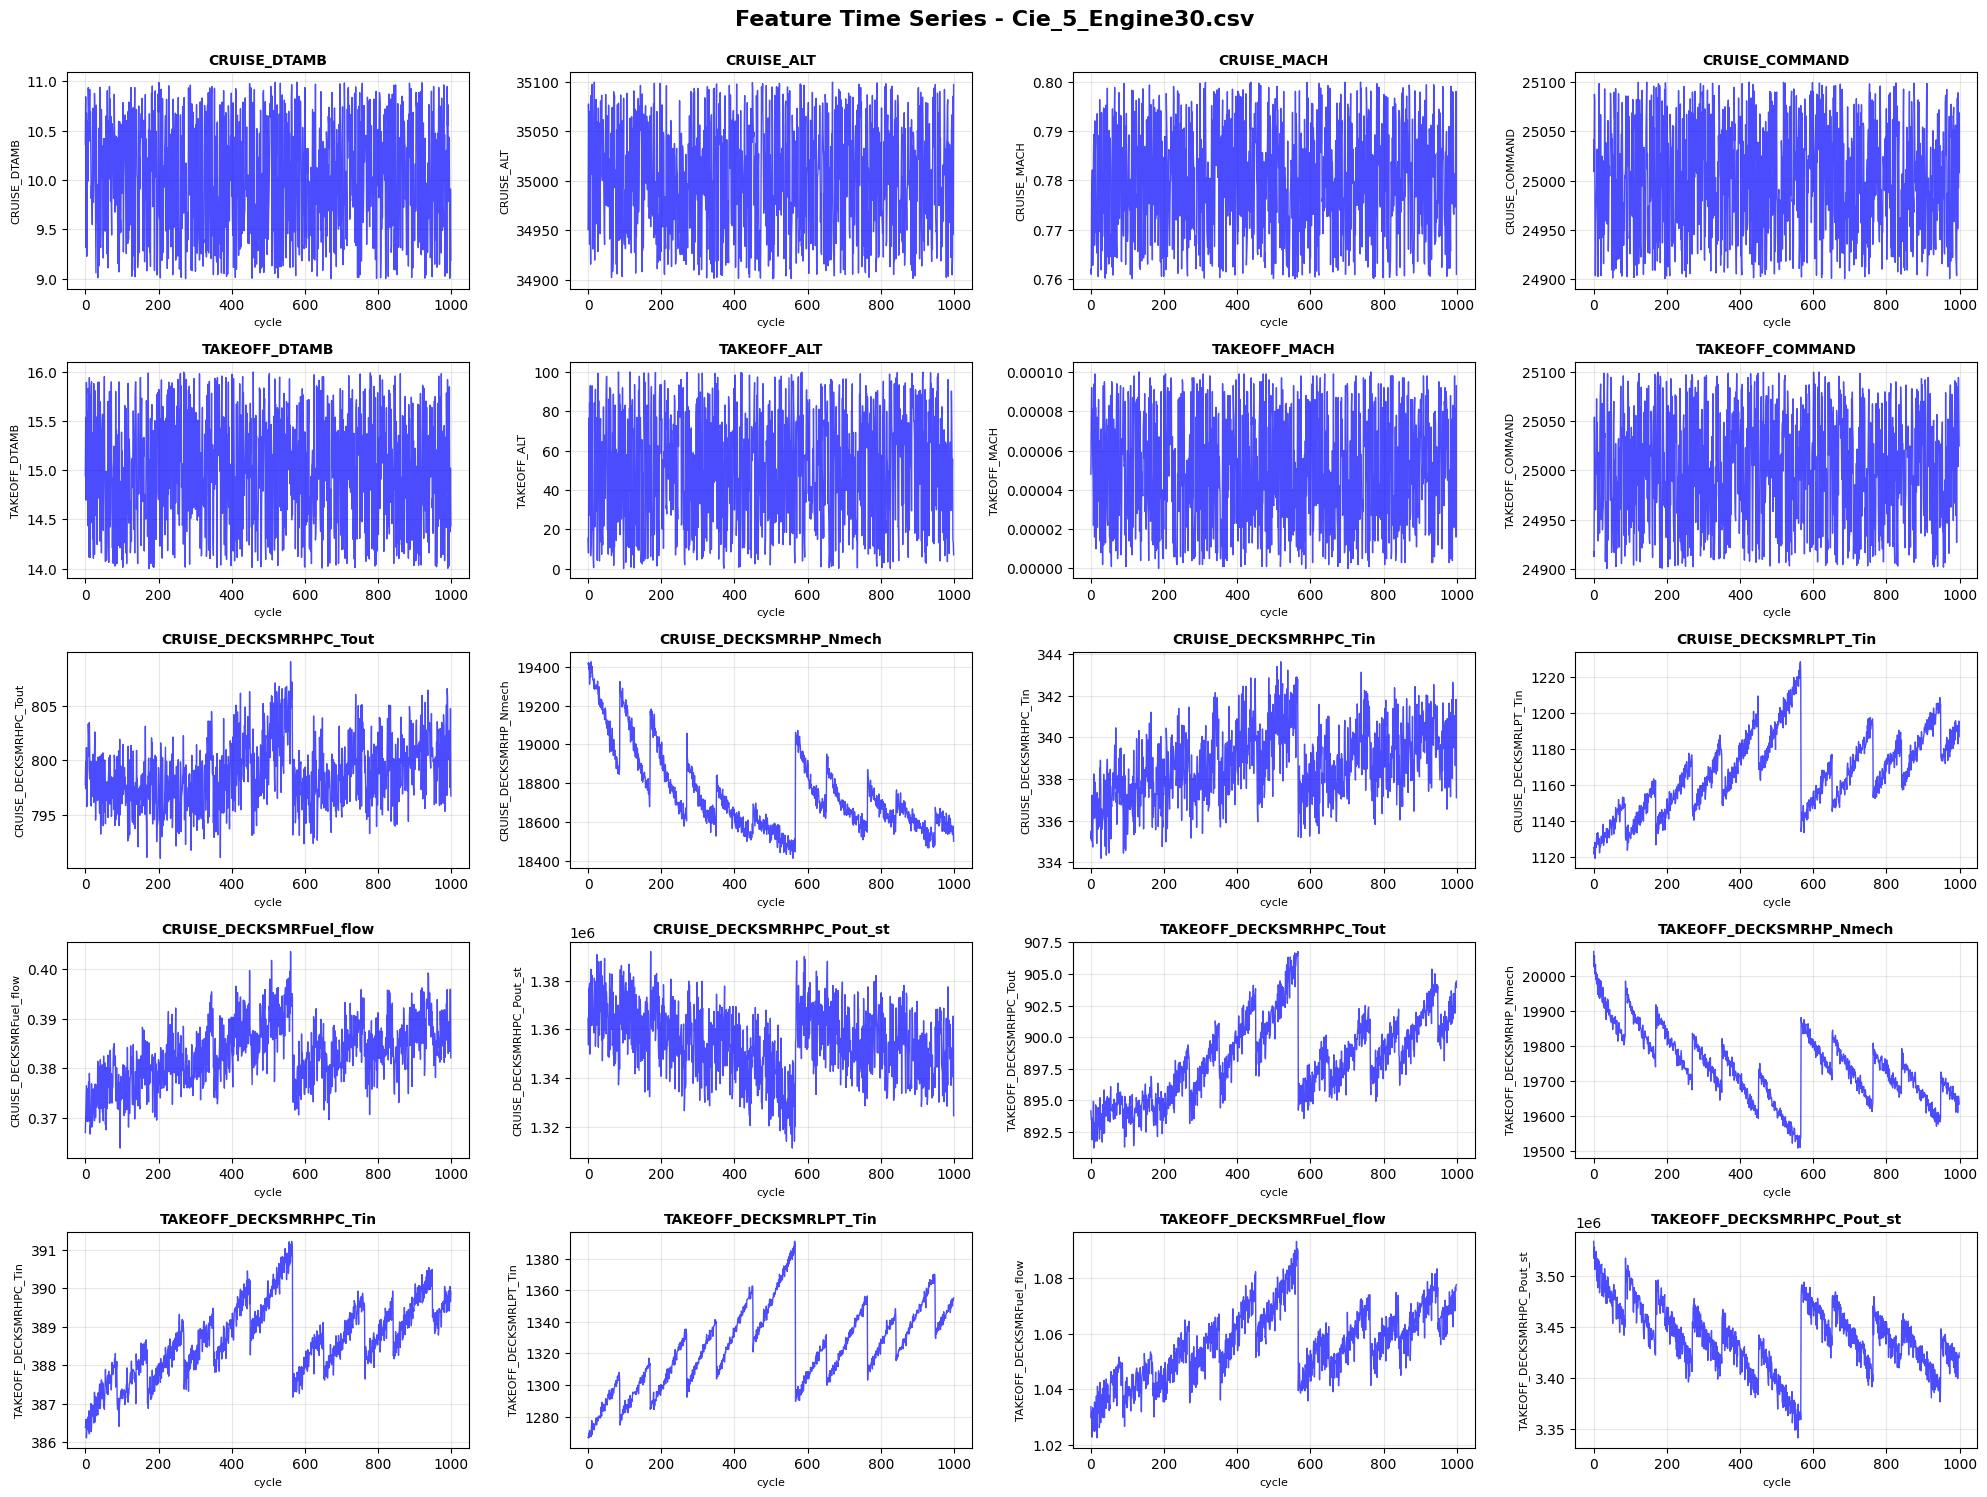

In [ ]:
time_col = 'cycle'
n_features = len(FEATURE_COLS)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axes = axes.flatten()

for i, feature in enumerate(FEATURE_COLS):
    ax = axes[i]
    ax.plot(df_single[time_col], df_single[feature], linewidth=1, color='blue', alpha=0.7)
    ax.set_title(feature, fontsize=10, fontweight='bold')
    ax.set_xlabel(time_col, fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
    ax.grid(alpha=0.3)
    
    # Display missing value count
    n_missing = df_single[feature].isnull().sum()
    if n_missing > 0:
        ax.text(0.02, 0.98, f'Missing: {n_missing}', 
                transform=ax.transAxes, fontsize=7, 
                verticalalignment='top', color='red')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle(f'Feature Time Series - {os.path.basename(selected_file)}', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

output_file = os.path.join(OUTPUT_DIR, f'timeseries_{os.path.basename(selected_file).replace(".csv", ".png")}')
plt.savefig(output_file, dpi=150, bbox_inches='tight')
#plt.close()

print(f"Saved: {output_file}")

## 6. Visualization: Time Series with Fault Markers

### 6.1 Check Fault Presence

Before plotting, we verify which faults actually occur in this engine. Some engines may have no faults (healthy operation) or only specific fault types.

In [ ]:
fault_present = {}
for fault in FAULT_COLS:
    if fault in df_single.columns:
        fault_present[fault] = (df_single[fault] == 1).any()
    else:
        fault_present[fault] = False

print("Fault presence in selected engine:")
for fault, present in fault_present.items():
    print(f"  {fault}: {'YES' if present else 'NO'}")

Fault presence in selected engine:
  corrosion: NO
  erosion: NO
  fouling: NO
  tip_clearance: YES


### 6.2 Plot Features with Fault Overlays

If faults are present, we overlay colored markers on the sensor readings:
- **Gray line**: Normal operation
- **Colored dots**: Cycles where specific faults occurred

This helps visualize:
- Which sensor readings change when faults occur
- Temporal relationships between faults and sensor behavior
- Whether multiple faults co-occur

Saved: /home/ensai/Desktop/SAFRAN_PROJECT/Project_ENSAI_2025/plots/timeseries_faults_Cie_5_Engine30.png


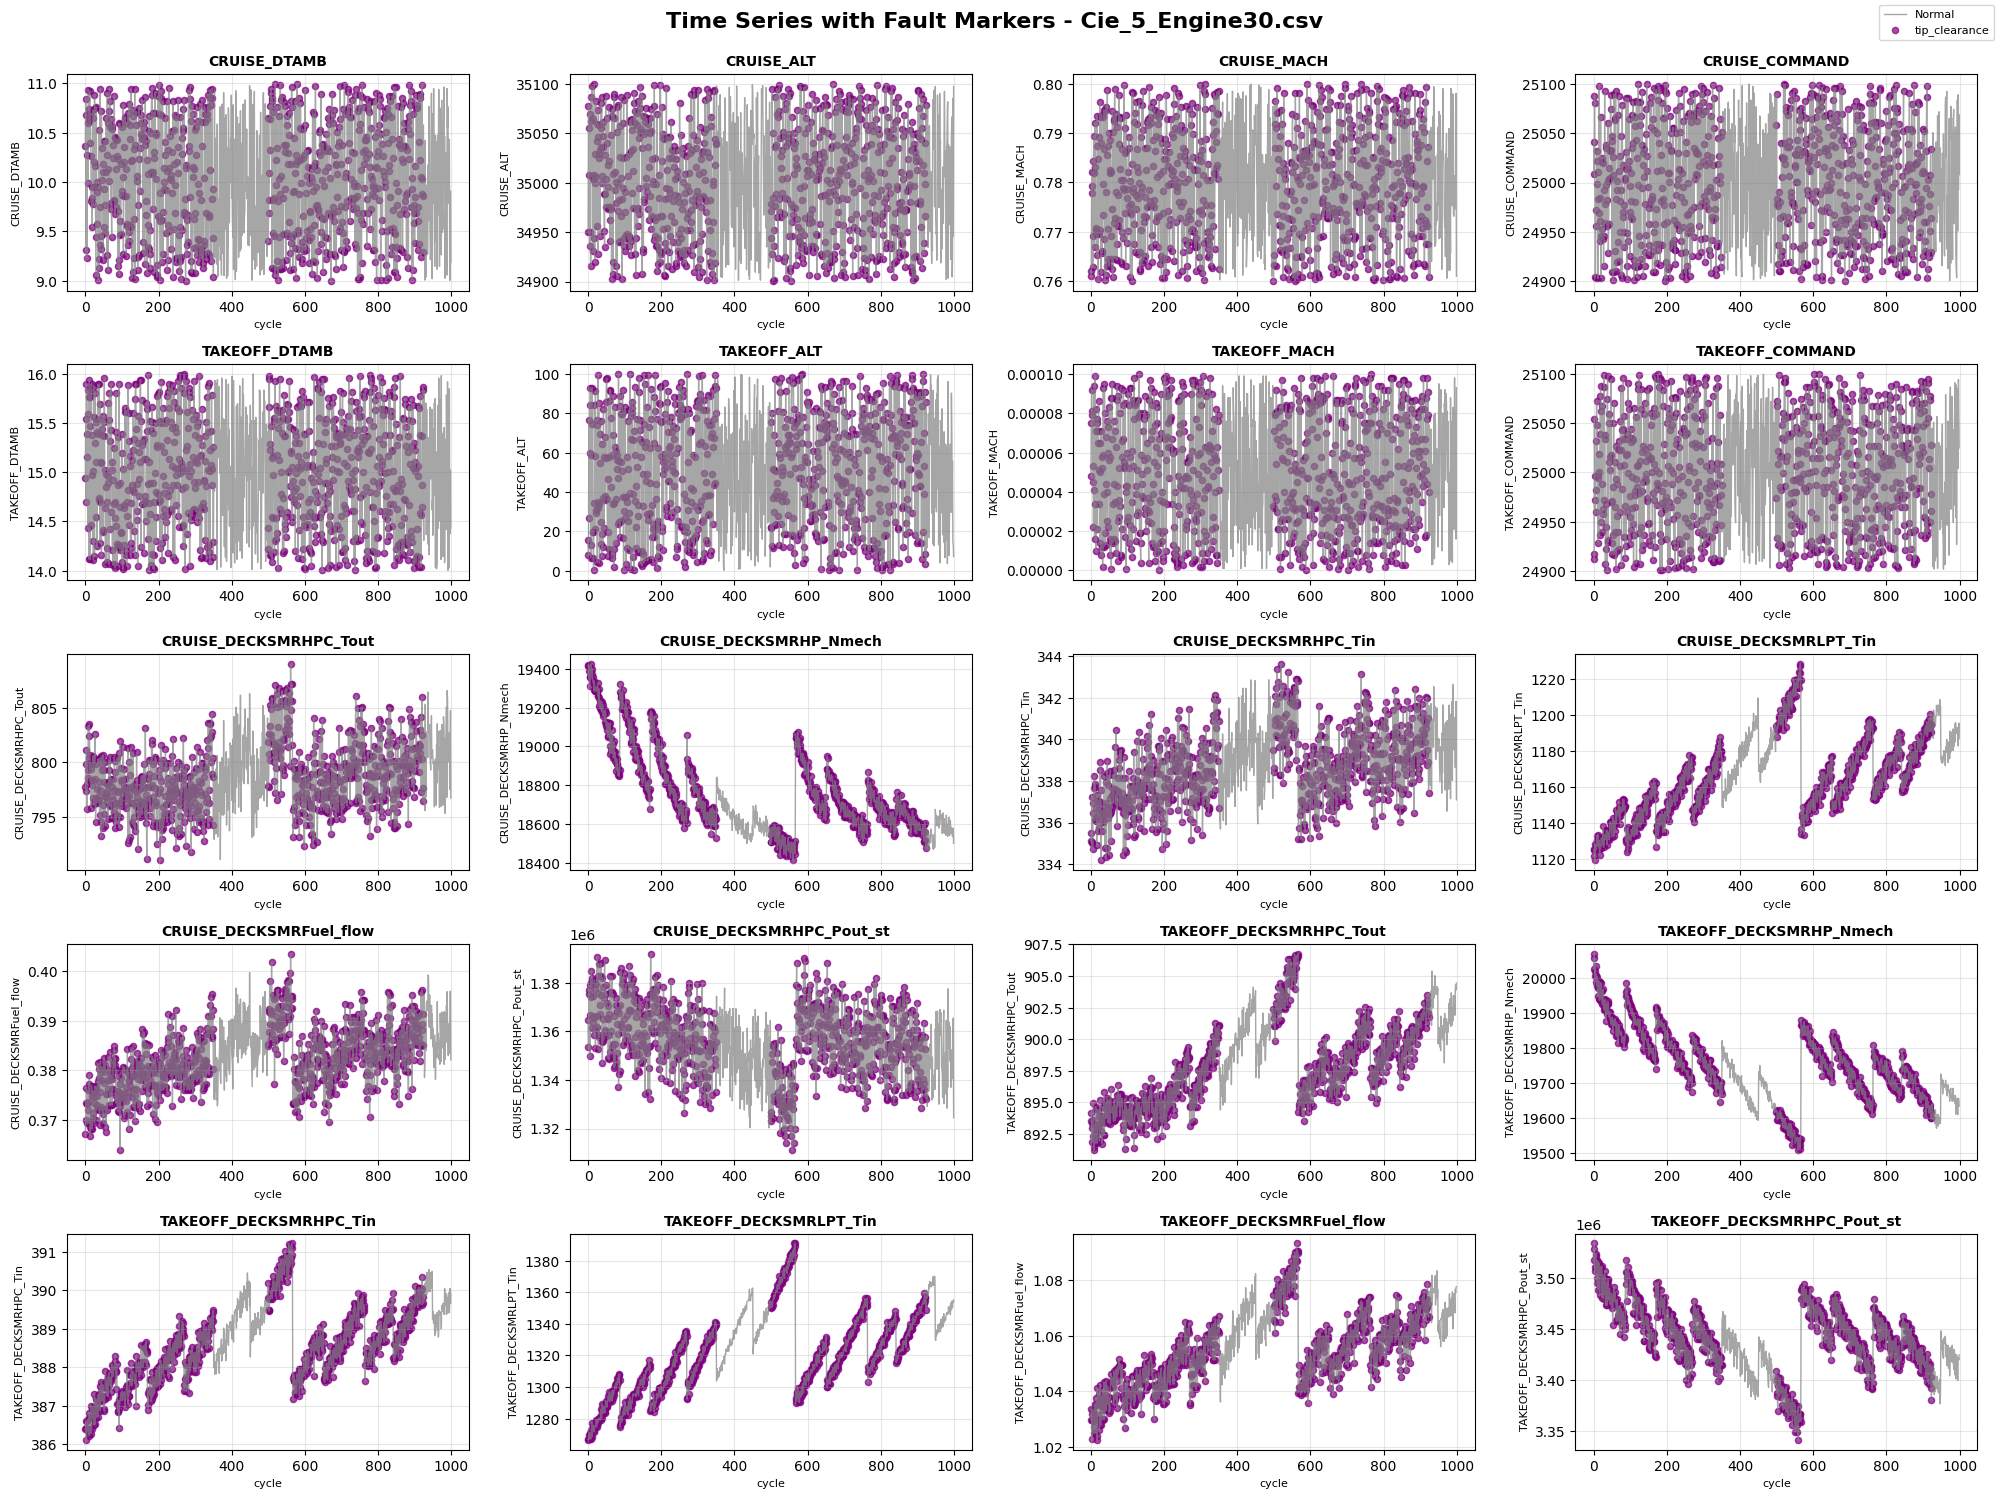

In [ ]:
if any(fault_present.values()):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
    axes = axes.flatten()
    
    for i, feature in enumerate(FEATURE_COLS):
        ax = axes[i]
        
        # Plot normal data
        ax.plot(df_single[time_col], df_single[feature], linewidth=1, 
                color='gray', alpha=0.7, label='Normal')
        
        # Add fault markers
        for fault in FAULT_COLS:
            if fault_present[fault] and fault in df_single.columns:
                fault_data = df_single[df_single[fault] == 1]
                if len(fault_data) > 0:
                    ax.scatter(fault_data[time_col], fault_data[feature], 
                              s=20, alpha=0.7, color=FAULT_COLORS[fault], 
                              label=fault, marker='o')
        
        ax.set_title(feature, fontsize=10, fontweight='bold')
        ax.set_xlabel(time_col, fontsize=8)
        ax.set_ylabel(feature, fontsize=8)
        ax.grid(alpha=0.3)
    
    # Create unified legend (avoid duplicates)
    handles, labels = [], []
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        for hh, ll in zip(h, l):
            if ll not in labels:
                handles.append(hh)
                labels.append(ll)
    
    fig.legend(handles, labels, loc='upper right', fontsize=8)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    fig.suptitle(f'Time Series with Fault Markers - {os.path.basename(selected_file)}', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    output_file = os.path.join(OUTPUT_DIR, f'timeseries_faults_{os.path.basename(selected_file).replace(".csv", ".png")}')
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    #plt.close()
    
    print(f"Saved: {output_file}")
else:
    print("No faults present - skipping fault overlay plot")

## 7. Visualization: Fault Timeline

### 7.1 Count Fault Occurrences

Calculate how many cycles each fault type appears in.

In [ ]:
print("Fault occurrences in selected engine:")
fault_counts = {}
for fault in FAULT_COLS:
    count = (df_single[fault] == 1).sum()
    fault_counts[fault] = count
    print(f"  {fault}: {count} occurrences")

Fault occurrences in selected engine:
  corrosion: 0 occurrences
  erosion: 0 occurrences
  fouling: 0 occurrences
  tip_clearance: 776 occurrences


### 7.2 Create Fault Timeline Plot

This plot shows **when** each fault type occurs over the engine's lifetime:
- X-axis: Cycle number (time)
- Y-axis: Fault type
- Vertical bars: Occurrences of each fault

**Patterns to observe:**
- Clustered faults: Do faults appear in bursts or continuously?
- Fault progression: Does one fault lead to others?
- Temporal distribution: Early-life vs. late-life failures


Plots saved to: /home/ensai/Desktop/SAFRAN_PROJECT/Project_ENSAI_2025/plots


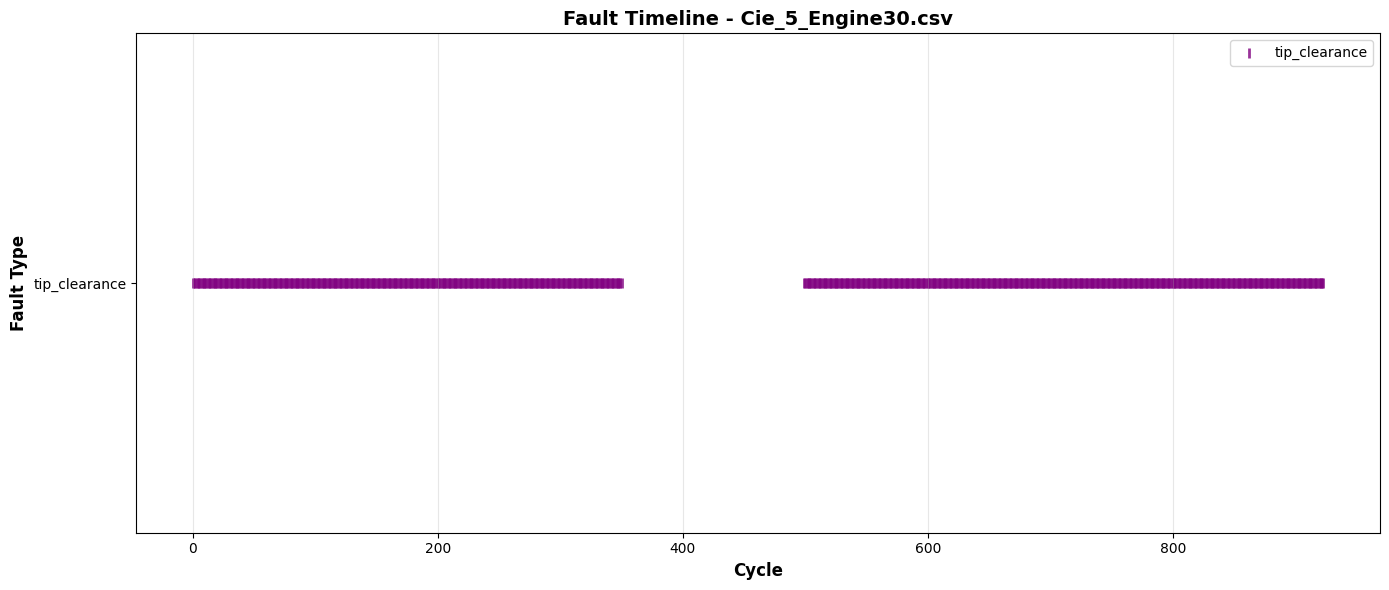

In [ ]:
if sum(fault_counts.values()) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    y_position = 0
    yticks, yticklabels = [], []
    
    for fault in FAULT_COLS:
        fault_cycles = df_single[df_single[fault] == 1][time_col]
        
        if len(fault_cycles) > 0:
            ax.scatter(fault_cycles, [y_position] * len(fault_cycles), 
                      s=50, marker='|', linewidths=2, 
                      color=FAULT_COLORS[fault], label=fault, alpha=0.8)
            
            yticks.append(y_position)
            yticklabels.append(fault)
            y_position += 1
    
    ax.set_xlabel('Cycle', fontsize=12, fontweight='bold')
    ax.set_ylabel('Fault Type', fontsize=12, fontweight='bold')
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_title(f'Fault Timeline - {os.path.basename(selected_file)}', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    
    output_file = os.path.join(OUTPUT_DIR, f'fault_timeline_{os.path.basename(selected_file).replace(".csv", ".png")}')
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    #plt.close()
    
    print(f"\nPlots saved to: {OUTPUT_DIR}")
else:
    print("No faults to plot")

## 8. Time Windowing for Fleet Analysis

### 8.1 Create Time Windows

To reduce noise and identify patterns, we aggregate cycles into windows:
- Each window contains `WINDOW_SIZE` consecutive cycles
- We calculate the **average fault occurrence** per window
- This transforms binary fault indicators (0/1) into fault frequencies (0.0-1.0)

**Example**: If `WINDOW_SIZE=40` and 10 cycles in a window have corrosion=1, the window's corrosion frequency is 10/40 = 0.25

In [ ]:
# Create window identifier for each cycle
ddf_fleet['cycle_window'] = (ddf_fleet['cycle'] // WINDOW_SIZE) * WINDOW_SIZE

### 8.2 Calculate Window-Level Fault Frequencies

Group all cycles by their window and compute mean fault occurrence across the entire fleet.

In [ ]:
windows_faults = ddf_fleet.groupby('cycle_window')[FAULT_COLS].mean().compute().sort_index()

print(f"\nCreated {len(windows_faults)} windows from {total_cycles_count:,} cycles")
print(f"Window size: {WINDOW_SIZE} cycles")
print("\nSample window data (first 10 windows):")
print(windows_faults.head(10))


Created 25 windows from 249,000 cycles
Window size: 40 cycles

Sample window data (first 10 windows):
              corrosion   erosion   fouling  tip_clearance
cycle_window                                              
0.0            0.160643  0.212851  0.204819       0.208835
40.0           0.160643  0.211245  0.204819       0.208333
80.0           0.165060  0.211747  0.204518       0.212550
120.0          0.179317  0.199699  0.214458       0.219076
160.0          0.192269  0.193173  0.206928       0.206124
200.0          0.210643  0.195382  0.214859       0.187349
240.0          0.206827  0.204518  0.226406       0.178815
280.0          0.191265  0.211044  0.219880       0.174900
320.0          0.175904  0.205622  0.214056       0.156325
360.0          0.168675  0.207129  0.197691       0.144880


### 8.3 Data Validation

Ensure we have valid windowed data before proceeding to clustering.

In [ ]:
if windows_faults.empty:
    raise ValueError("No windowed data available. Check 'cycle' values and WINDOW_SIZE.")

## 9. K-Means Clustering for Change Point Detection

### 9.1 Why K-Means?

K-means clustering helps identify **operational regimes** - distinct periods with different fault patterns:
- **Healthy regime**: Low/no fault frequencies
- **Degrading regime**: Increasing fault frequencies
- **Failed regime**: High fault frequencies

By clustering windows, we can automatically detect transitions between these regimes.

### 9.2 Prepare Data for Clustering

In [ ]:
X = windows_faults.to_numpy()
n_samples = len(X)

print(f"Clustering input: {n_samples} windows × {len(FAULT_COLS)} fault types")
print(f"Data shape: {X.shape}")

Clustering input: 25 windows × 4 fault types
Data shape: (25, 4)


## 10. Optimal K Selection

### 10.1 Elbow Method and Silhouette Score

We use two methods to find the optimal number of clusters:

**1. Elbow Method (WCSS)**:
- WCSS = Within-Cluster Sum of Squares
- Measures compactness of clusters
- Look for the "elbow" where WCSS decrease slows

**2. Silhouette Score**:
- Measures how well-separated clusters are
- Range: [-1, 1], higher is better
- Considers both cluster cohesion and separation

We'll test K from 2 to min(10, n_samples) and select K with the highest silhouette score.

In [ ]:
K_range = range(2, min(10, n_samples))

wcss = []
silhouette_scores = []

print(f"Testing K from 2 to {max(K_range)}...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Calculate WCSS (inertia)
    wcss.append(kmeans.inertia_)
    
    # Calculate silhouette score
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    
    print(f"  K={k}: WCSS={kmeans.inertia_:.4f}, Silhouette={score:.4f}")

Testing K from 2 to 9...
  K=2: WCSS=0.0174, Silhouette=0.3447
  K=3: WCSS=0.0123, Silhouette=0.3542
  K=4: WCSS=0.0098, Silhouette=0.3202
  K=5: WCSS=0.0072, Silhouette=0.3768
  K=6: WCSS=0.0057, Silhouette=0.3561
  K=7: WCSS=0.0043, Silhouette=0.3872
  K=8: WCSS=0.0033, Silhouette=0.4228
  K=9: WCSS=0.0027, Silhouette=0.4601


### 10.2 Visualize Elbow Curve

Plot WCSS vs. K to identify the elbow point visually.


Elbow plot saved: /home/ensai/Desktop/SAFRAN_PROJECT/Project_ENSAI_2025/plots/elbow_method.png


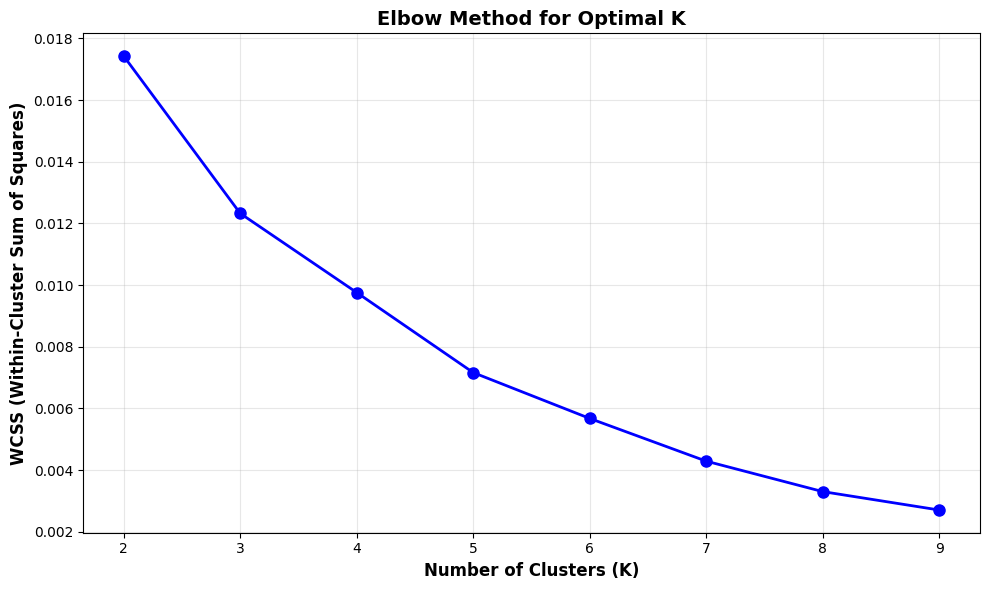

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12, fontweight='bold')
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.xticks(K_range)

output_file = os.path.join(OUTPUT_DIR, "elbow_method.png")
plt.tight_layout()
plt.savefig(output_file, dpi=150)
#plt.close()

print(f"\nElbow plot saved: {output_file}")

### 10.3 Select Optimal K

Choose K with the highest silhouette score.

In [ ]:
optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
max_silhouette = max(silhouette_scores)

print(f"\nOptimal K: {optimal_k}")
print(f"Best silhouette score: {max_silhouette:.4f}")


Optimal K: 9
Best silhouette score: 0.4601


## 11. Create Regime Windows

### 11.1 Why Regime-Based Windows?

Instead of fixed-size windows, we now create **regime windows** where:
- The total operational time is divided into `optimal_k` regimes
- Each regime represents a distinct operational phase
- This allows the majority vote classifier to work on meaningful time segments

**Formula**: `window_size_k = total_cycles / optimal_k`

This ensures each regime has approximately equal duration.

In [ ]:
window_size_k = total_cycles_count / optimal_k
ddf_fleet['cycle_window_k'] = (ddf_fleet['cycle'] // window_size_k) * window_size_k

print(f"\nCreated {optimal_k} regime windows")
print(f"Each regime covers ~{window_size_k:.0f} cycles")


Created 9 regime windows
Each regime covers ~27667 cycles


### 11.2 Calculate Fault Frequencies per Regime

In [ ]:
windows_faults_k = ddf_fleet.groupby('cycle_window_k')[FAULT_COLS].mean().compute().sort_index()

print("\nRegime-level fault frequencies (first 10 regimes):")
print(windows_faults_k.head(10))


Regime-level fault frequencies (first 10 regimes):
                corrosion   erosion   fouling  tip_clearance
cycle_window_k                                              
0.0              0.178004  0.205888  0.214133       0.191446


## 12. Majority Vote Classifier

### 12.1 Classifier Logic

For each regime window, the majority vote classifier:
1. Counts occurrences of each fault type
2. Identifies the **dominant fault** (most frequent)
3. Assigns prediction=1 for that fault, 0 for others

**Key constraint**: Only ONE fault type gets prediction=1 per regime

This creates a simplified representation where each time period is characterized by its primary fault mode.

### 12.2 Initialize Prediction Columns

In [ ]:
print("\n" + "="*60)
print("MAJORITY VOTE CLASSIFIER")
print("="*60)

FAULT_PREDICT_COLS = [f'{fault}_predict' for fault in FAULT_COLS]

for col in FAULT_PREDICT_COLS:
    ddf_fleet[col] = 0

print(f"\nCreated prediction columns: {FAULT_PREDICT_COLS}")


MAJORITY VOTE CLASSIFIER

Created prediction columns: ['corrosion_predict', 'erosion_predict', 'fouling_predict', 'tip_clearance_predict']


### 12.3 Apply Majority Vote

Convert to Pandas for efficient iteration and apply majority voting logic.

In [ ]:
print("\nApplying majority vote (this may take a moment)...")
df_fleet = ddf_fleet.compute()

for window in df_fleet['cycle_window_k'].unique():
    window_mask = df_fleet['cycle_window_k'] == window
    window_data = df_fleet[window_mask]
    
    # Count fault occurrences in this window
    fault_counts = {fault: (window_data[fault] == 1).sum() for fault in FAULT_COLS}
    
    # Find dominant fault (if any)
    if sum(fault_counts.values()) > 0:
        winning_fault = max(fault_counts, key=fault_counts.get)
        predict_col = f'{winning_fault}_predict'
        df_fleet.loc[window_mask, predict_col] = 1

print("Majority vote applied successfully.")


Applying majority vote (this may take a moment)...
Majority vote applied successfully.


## 13. Performance Evaluation

### 13.1 Metrics Explanation

We evaluate the classifier using standard classification metrics:

**Accuracy**: (TP + TN) / Total
- Overall correctness
- Can be misleading with imbalanced classes

**Precision**: TP / (TP + FP)
- When we predict fault=1, how often are we correct?
- Important when false alarms are costly

**Recall**: TP / (TP + FN)
- Of all actual faults, how many did we detect?
- Important when missing faults is dangerous

**F1-Score**: 2 × (Precision × Recall) / (Precision + Recall)
- Harmonic mean balancing precision and recall

**Confusion Matrix**: `[[TN, FP], [FN, TP]]`
- Shows all four prediction outcomes

### 13.2 Per-Fault Performance

In [ ]:
print("\n" + "="*60)
print("CLASSIFIER PERFORMANCE")
print("="*60)

for i, fault in enumerate(FAULT_COLS):
    predict_col = FAULT_PREDICT_COLS[i]
    
    y_true = df_fleet[fault]
    y_pred = df_fleet[predict_col]
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n{fault.upper()}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  Confusion Matrix:")
    print(f"    [[TN={cm[0,0]}, FP={cm[0,1]}]]")
    print(f"    [[FN={cm[1,0]}, TP={cm[1,1]}]]")


CLASSIFIER PERFORMANCE

CORROSION:
  Accuracy:  0.8220
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  Confusion Matrix:
    [[TN=204677, FP=0]]
    [[FN=44323, TP=0]]

EROSION:
  Accuracy:  0.7941
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  Confusion Matrix:
    [[TN=197734, FP=0]]
    [[FN=51266, TP=0]]

FOULING:
  Accuracy:  0.2141
  Precision: 0.2141
  Recall:    1.0000
  F1-Score:  0.3527
  Confusion Matrix:
    [[TN=0, FP=195681]]
    [[FN=0, TP=53319]]

TIP_CLEARANCE:
  Accuracy:  0.8086
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  Confusion Matrix:
    [[TN=201330, FP=0]]
    [[FN=47670, TP=0]]


### 13.3 Overall Performance

Calculate aggregate accuracy across all fault types and all cycles.

In [ ]:
print("\n" + "-"*60)
print("OVERALL PERFORMANCE:")

overall_accuracy = accuracy_score(
    df_fleet[FAULT_COLS].values.flatten(),
    df_fleet[FAULT_PREDICT_COLS].values.flatten()
)

print(f"  Overall Accuracy: {overall_accuracy:.4f}")
print("="*60)


------------------------------------------------------------
OVERALL PERFORMANCE:
  Overall Accuracy: 0.6597


# Rolling windows 

In [7]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data

def create_rolling_windows(data, labels, window_size, stride=1):
    """
    Crea rolling windows dai dati temporali.
    
    Parameters:
    -----------
    data : array-like, shape (n_samples, n_timesteps, n_features)
        Dati originali delle serie temporali
    labels : array-like, shape (n_samples,)
        Etichette associate a ogni serie temporale
    window_size : int
        Dimensione della finestra temporale
    stride : int, default=1
        Passo di scorrimento della finestra (1 = finestre sovrapposte)
    
    Returns:
    --------
    windows : array, shape (n_windows, window_size, n_features)
        Array con tutte le finestre estratte
    window_labels : array, shape (n_windows,)
        Etichette associate a ogni finestra
    """
    windows = []
    window_labels = []
    
    for sample_idx in range(len(data)):
        sample = data[sample_idx]  # Shape: (n_timesteps, n_features)
        label = labels[sample_idx]
        n_timesteps = sample.shape[0]
        
        # Crea finestre per questo sample
        for start_idx in range(0, n_timesteps - window_size + 1, stride):
            end_idx = start_idx + window_size
            window = sample[start_idx:end_idx, :]
            windows.append(window)
            window_labels.append(label)
    
    return np.array(windows), np.array(window_labels)


# ==========================================
# INTEGRAZIONE NEL NOTEBOOK ESISTENTE
# Inserisci questo codice DOPO la sezione di standardizzazione
# e PRIMA della costruzione del grafo
# ==========================================

# Parametri della finestra
WINDOW_SIZE = 50  # timesteps per finestra
STRIDE = 25       # sovrapposizione del 50%

# Applica rolling windows ai dati standardizzati
print("Creating rolling windows for training data...")
X_train_windowed, y_train_windowed = create_rolling_windows(
    X_train_scaled,  # Usa i dati già standardizzati
    y_train, 
    window_size=WINDOW_SIZE,
    stride=STRIDE
)

print("Creating rolling windows for test data...")
X_test_windowed, y_test_windowed = create_rolling_windows(
    X_test_scaled,   # Usa i dati già standardizzati
    y_test, 
    window_size=WINDOW_SIZE,
    stride=STRIDE
)

print(f"\nOriginal training samples: {len(X_train_scaled)}")
print(f"Training windows created: {len(X_train_windowed)}")
print(f"Original test samples: {len(X_test_scaled)}")
print(f"Test windows created: {len(X_test_windowed)}")
print(f"Window shape: {X_train_windowed.shape}")

# Aggiorna le variabili per usare le finestre
# (commenta le righe originali e usa queste)
# X_train_scaled = X_train_windowed  # Decommentare per usare windows
# y_train = y_train_windowed
# X_test_scaled = X_test_windowed
# y_test = y_test_windowed

# ==========================================
# MODIFICA NELLA SEZIONE DI COSTRUZIONE DEL GRAFO
# Sostituisci la creazione dei Data objects con questo:
# ==========================================

# Costruisci il grafo (questo rimane uguale)
edge_index = build_sensor_graph(
    num_nodes=num_sensors,
    correlation_matrix=correlation_matrix,
    threshold=threshold
)

# Converti in tensori PyTorch usando le finestre
print("\nConverting windowed data to PyTorch Geometric format...")

train_data_list = []
for i in range(len(X_train_windowed)):
    # Ogni finestra diventa un Data object separato
    x = torch.FloatTensor(X_train_windowed[i])  # Shape: (window_size, num_sensors)
    y = torch.LongTensor([y_train_windowed[i]])
    
    data = Data(
        x=x,
        edge_index=edge_index,
        y=y
    )
    train_data_list.append(data)

test_data_list = []
for i in range(len(X_test_windowed)):
    x = torch.FloatTensor(X_test_windowed[i])
    y = torch.LongTensor([y_test_windowed[i]])
    
    data = Data(
        x=x,
        edge_index=edge_index,
        y=y
    )
    test_data_list.append(data)

print(f"Created {len(train_data_list)} training graphs")
print(f"Created {len(test_data_list)} test graphs")

# Il resto del codice rimane identico
# (DataLoader, model definition, training loop, etc.)

ModuleNotFoundError: No module named 'torch_geometric'

# DNN MODEL 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [11]:

class IIRFilter(nn.Module):
    """
    IIR (Infinite Impulse Response) filter come nel paper.
    Genera dinamiche tra input e output del neurone.
    """
    def __init__(self, order=2):
        super(IIRFilter, self).__init__()
        self.order = order
        
        # Coefficienti del numeratore (feedforward)
        self.b = nn.Parameter(torch.randn(order + 1) * 0.01)
        
        # Coefficienti del denominatore (feedback) - inizializzati a zero per stabilità
        self.a = nn.Parameter(torch.zeros(order))
        
        # Buffer per memorizzare gli stati passati
        self.register_buffer('x_buffer', torch.zeros(order + 1))
        self.register_buffer('y_buffer', torch.zeros(order))
        
    def forward(self, x):
        """
        Implementa l'equazione IIR:
        y[n] = sum(b[k]*x[n-k]) - sum(a[k]*y[n-k])
        """
        batch_size = x.size(0)
        output = torch.zeros(batch_size, 1, device=x.device)
        
        for i in range(batch_size):
            # Aggiorna il buffer degli input
            self.x_buffer = torch.cat([x[i:i+1], self.x_buffer[:-1]])
            
            # Calcola output: parte feedforward
            y_n = torch.sum(self.b * self.x_buffer)
            
            # Parte feedback
            y_n = y_n - torch.sum(self.a * self.y_buffer)
            
            # Aggiorna il buffer degli output
            self.y_buffer = torch.cat([y_n.unsqueeze(0), self.y_buffer[:-1]])
            
            output[i] = y_n
            
        return output
    
    def reset_states(self):
        """Reset degli stati interni del filtro"""
        self.x_buffer.zero_()
        self.y_buffer.zero_()


class DynamicNeuron(nn.Module):
    """
    Neurone dinamico con filtro IIR integrato.
    Struttura: input -> IIR filter -> activation function -> output
    """
    def __init__(self, input_size, filter_order=2):
        super(DynamicNeuron, self).__init__()
        
        # Pesi di connessione
        self.weights = nn.Parameter(torch.randn(input_size) * 0.1)
        self.bias = nn.Parameter(torch.randn(1) * 0.1)
        
        # Filtro IIR
        self.iir_filter = IIRFilter(order=filter_order)
        
        # Slope dell'activation function (parametro adattivo)
        self.slope = nn.Parameter(torch.ones(1))
        
    def forward(self, x):
        # Combinazione lineare pesata
        z = torch.matmul(x, self.weights) + self.bias
        
        # Passa attraverso il filtro IIR
        z_filtered = self.iir_filter(z.unsqueeze(-1))
        
        # Activation function (tanh con slope adattivo)
        output = torch.tanh(self.slope * z_filtered)
        
        return output.squeeze(-1)


class DynamicNeuralNetwork(nn.Module):
    """
    Dynamic Neural Network completa come nel paper.
    Architettura: Input -> Hidden Layers (dynamic neurons) -> Output Layer
    """
    def __init__(self, input_size, hidden_sizes, output_size, filter_order=2):
        super(DynamicNeuralNetwork, self).__init__()
        
        self.hidden_sizes = hidden_sizes
        self.layers = nn.ModuleList()
        
        # Primo hidden layer
        prev_size = input_size
        
        # Hidden layers con neuroni dinamici
        for hidden_size in hidden_sizes:
            layer = nn.ModuleList([
                DynamicNeuron(prev_size, filter_order) 
                for _ in range(hidden_size)
            ])
            self.layers.append(layer)
            prev_size = hidden_size
        
        # Output layer (lineare come nel paper)
        self.output_layer = nn.Linear(prev_size, output_size)
        
    def forward(self, x):
        # Forward pass attraverso gli hidden layers
        for layer in self.layers:
            layer_output = []
            for neuron in layer:
                layer_output.append(neuron(x))
            x = torch.stack(layer_output, dim=1)
        
        # Output layer
        output = self.output_layer(x)
        
        return output
    
    def reset_states(self):
        """Reset di tutti i filtri IIR nella rete"""
        for layer in self.layers:
            for neuron in layer:
                neuron.iir_filter.reset_states()


class EngineFaultDetector:
    """
    Sistema di fault detection per motori aeronautici basato su DNN.
    Implementa la strategia del paper: un DNN per ogni variabile di output.
    """
    def __init__(self, input_size=1, hidden_sizes=[5, 5], filter_order=2):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.filter_order = filter_order
        
        # Dizionario per memorizzare un DNN per ogni sensore
        self.networks = {}
        self.scalers_input = {}
        self.scalers_output = {}
        self.thresholds = {}
        
    def create_network(self, sensor_name):
        """Crea un DNN per un sensore specifico"""
        network = DynamicNeuralNetwork(
            input_size=self.input_size,
            hidden_sizes=self.hidden_sizes,
            output_size=1,
            filter_order=self.filter_order
        )
        self.networks[sensor_name] = network
        self.scalers_input[sensor_name] = MinMaxScaler()
        self.scalers_output[sensor_name] = MinMaxScaler()
        
        return network
    
    def prepare_data(self, fuel_flow, sensor_data, sensor_name):
        """
        Prepara i dati per il training (normalizzazione)
        """
        # Normalizzazione input (fuel flow)
        X = self.scalers_input[sensor_name].fit_transform(
            fuel_flow.reshape(-1, 1)
        )
        
        # Normalizzazione output (sensor data)
        y = self.scalers_output[sensor_name].fit_transform(
            sensor_data.reshape(-1, 1)
        )
        
        return torch.FloatTensor(X), torch.FloatTensor(y)
    
    def train_network(self, sensor_name, X, y, epochs=5000, lr=0.0006, 
                     batch_size=32, patience=200):
        """
        Training del DNN per un sensore specifico.
        Usa Extended Dynamic Backpropagation.
        """
        network = self.networks[sensor_name]
        optimizer = optim.Adam(network.parameters(), lr=lr)
        criterion = nn.MSELoss()
        
        # Split train/validation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, shuffle=False
        )
        
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            network.train()
            epoch_loss = 0
            
            # Training in mini-batches
            for i in range(0, len(X_train), batch_size):
                batch_X = X_train[i:i+batch_size]
                batch_y = y_train[i:i+batch_size]
                
                # Reset degli stati del filtro IIR ad ogni batch
                network.reset_states()
                
                optimizer.zero_grad()
                
                # Forward pass
                predictions = network(batch_X)
                loss = criterion(predictions, batch_y)
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping per stabilità
                torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                epoch_loss += loss.item()
            
            # Validation
            network.eval()
            with torch.no_grad():
                network.reset_states()
                val_predictions = network(X_val)
                val_loss = criterion(val_predictions, y_val).item()
            
            train_losses.append(epoch_loss / (len(X_train) / batch_size))
            val_losses.append(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Salva il miglior modello
                self.best_state = network.state_dict().copy()
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                network.load_state_dict(self.best_state)
                break
            
            if (epoch + 1) % 500 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.6f}, '
                      f'Val Loss: {val_losses[-1]:.6f}')
        
        return train_losses, val_losses
    
    def compute_threshold(self, sensor_name, X, y, n_simulations=100):
        """
        Calcola la threshold per fault detection tramite Monte Carlo.
        Simula rumore per determinare il massimo errore in condizioni normali.
        """
        network = self.networks[sensor_name]
        network.eval()
        
        max_residuals = []
        
        with torch.no_grad():
            for _ in range(n_simulations):
                # Aggiungi rumore gaussiano
                noise_level = 0.005  # 0.5% come nel paper
                X_noisy = X + torch.randn_like(X) * noise_level
                
                network.reset_states()
                predictions = network(X_noisy)
                
                # Denormalizza per calcolare il residual reale
                pred_denorm = self.scalers_output[sensor_name].inverse_transform(
                    predictions.numpy()
                )
                y_denorm = self.scalers_output[sensor_name].inverse_transform(
                    y.numpy()
                )
                
                residuals = np.abs(pred_denorm - y_denorm)
                max_residuals.append(np.max(residuals))
        
        # La threshold è la media dei massimi residuals
        threshold = np.mean(max_residuals)
        self.thresholds[sensor_name] = threshold
        
        return threshold
    
    def detect_fault(self, sensor_name, fuel_flow, sensor_data):
        """
        Rileva fault confrontando il residual con la threshold.
        """
        network = self.networks[sensor_name]
        network.eval()
        
        # Normalizza i dati
        X = self.scalers_input[sensor_name].transform(
            fuel_flow.reshape(-1, 1)
        )
        X = torch.FloatTensor(X)
        
        with torch.no_grad():
            network.reset_states()
            predictions = network(X)
            
            # Denormalizza
            pred_denorm = self.scalers_output[sensor_name].inverse_transform(
                predictions.numpy()
            )
        
        # Calcola residual
        residuals = np.abs(pred_denorm.flatten() - sensor_data)
        
        # Fault detection
        fault_detected = residuals > self.thresholds[sensor_name]
        
        return residuals, fault_detected, pred_denorm.flatten()
    
    def visualize_training(self, train_losses, val_losses, sensor_name):
        """Visualizza le curve di training"""
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.title(f'Training Progress - {sensor_name}')
        plt.legend()
        plt.yscale('log')
        plt.grid(True)
        plt.tight_layout()
        return plt
    
    def visualize_prediction(self, fuel_flow, actual, predicted, residuals, 
                           sensor_name, fault_detected=None):
        """Visualizza predizioni e residuals"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        time = np.arange(len(fuel_flow))
        
        # Plot predizioni vs actual
        ax1.plot(time, actual, 'b-', label='Actual', linewidth=1)
        ax1.plot(time, predicted, 'r--', label='DNN Prediction', linewidth=1)
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel(sensor_name)
        ax1.set_title(f'{sensor_name} - Actual vs Predicted')
        ax1.legend()
        ax1.grid(True)
        
        # Plot residuals con threshold
        ax2.plot(time, residuals, 'g-', label='Residual', linewidth=1)
        if sensor_name in self.thresholds:
            threshold = self.thresholds[sensor_name]
            ax2.axhline(y=threshold, color='r', linestyle='--', 
                       label=f'Threshold ({threshold:.4f})')
            
            if fault_detected is not None:
                fault_times = time[fault_detected]
                if len(fault_times) > 0:
                    ax2.scatter(fault_times, residuals[fault_detected], 
                              color='red', s=50, label='Fault Detected', 
                              zorder=5, alpha=0.6)
        
        ax2.set_xlabel('Time Step')
        ax2.set_ylabel('Residual Error')
        ax2.set_title(f'{sensor_name} - Residual Signal')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        return fig

# Trainging Model 

In [12]:
 #=============================================================================
# ESEMPIO DI UTILIZZO CON I TUOI DATI
# =============================================================================

# Carica i dati

print("Colonne disponibili:", df.columns.tolist())
print("\nShape:", df.shape)

# Identifica le colonne rilevanti
# Supponiamo che la prima colonna sia il fuel flow e le altre i sensori
# MODIFICA QUESTI NOMI IN BASE AI TUOI DATI REALI

fuel_column = df.columns[0]  # Modifica con il nome corretto
sensor_columns = df.columns[1:9]  # Modifica con i nomi corretti degli 8 sensori

print(f"\nFuel flow column: {fuel_column}")
print(f"Sensor columns: {sensor_columns.tolist()}")

# Crea il detector
detector = EngineFaultDetector(
    input_size=1,
    hidden_sizes=[5, 5],  # Come nel paper: 1-5-5-1
    filter_order=2
)

# Training per un sensore di esempio (modifica con il sensore che vuoi)
example_sensor = sensor_columns[0]  # Prendi il primo sensore
print(f"\n{'='*60}")
print(f"Training DNN per sensore: {example_sensor}")
print(f"{'='*60}")

# Estrai i dati
fuel_flow = df[fuel_column].values
sensor_data = df[example_sensor].values

# Crea la rete per questo sensore
detector.create_network(example_sensor)

# Prepara i dati
X, y = detector.prepare_data(fuel_flow, sensor_data, example_sensor)

# Training
train_losses, val_losses = detector.train_network(
    example_sensor, X, y,
    epochs=5000,
    lr=0.0006,
    batch_size=32,
    patience=200
)

# Visualizza training
fig1 = detector.visualize_training(train_losses, val_losses, example_sensor)
plt.show()

# Calcola threshold
threshold = detector.compute_threshold(example_sensor, X, y, n_simulations=100)
print(f"\nThreshold calcolata per {example_sensor}: {threshold:.6f}")

# Test e fault detection
residuals, fault_detected, predictions = detector.detect_fault(
    example_sensor, fuel_flow, sensor_data
)

print(f"\nFault detected: {np.any(fault_detected)}")
if np.any(fault_detected):
    print(f"Numero di time steps con fault: {np.sum(fault_detected)}")
    print(f"Primi time steps con fault: {np.where(fault_detected)[0][:10]}")

# Visualizza risultati
fig2 = detector.visualize_prediction(
    fuel_flow, sensor_data, predictions, residuals, 
    example_sensor, fault_detected
)
plt.show()

print("\n" + "="*60)
print("Training completato!")
print("="*60)

NameError: name 'df' is not defined